In [1]:
import numpy as np
import matplotlib.pyplot as plt

from functions.pressure_conversion import pressure_conversion
from Ausgleichsbecken.Ausgleichsbecken_class_file import Ausgleichsbecken_class
from Regler.Regler_class_file import PI_controller_class

In [2]:
# define reservoir constants
initial_level               = 5.        # m
initial_influx              = 1.       # m³/s
initial_outflux             = 0.        # m³/s
initial_pipeline_pressure   = 5.
initial_pressure_unit       = 'mWS'
conversion_pressure_unit    = 'mWS'

area_base                   = 1.        # m²
area_outflux                = 0.5       # m²
critical_level_low          = 0.        # m
critical_level_high         = 10.       # m
simulation_timestep         = 0.001     # s

# for while loop
total_min_level             = 0.01      # m
total_max_time              = 200       # s

In [3]:
# define controller constants
target_level = 4.5  # m
Kp = 0.01
Ti = 120

deadband_range = 0.1 # m
deadband_lo = target_level-deadband_range
deadband_hi = target_level+deadband_range



In [4]:
# define pressure modulation function
d_ppfun_max = +0.001
d_pp_fun_max_unit = 'mWS'
d_ppfun_min = -0.001
d_pp_fun_min_unit = 'mWS'

d_pp_max,_ = pressure_conversion(d_ppfun_max,d_pp_fun_max_unit,'Pa')
d_pp_min,_ = pressure_conversion(d_ppfun_min,d_pp_fun_min_unit,'Pa')

pp_fun_max = +1.1*target_level
pp_fun_max_unit = 'mWS'
pp_fun_min = +0.5*target_level
pp_fun_min_unit = 'mWS'

pp_max,_ = pressure_conversion(pp_fun_max,pp_fun_max_unit,'Pa')
pp_min,_ = pressure_conversion(pp_fun_min,pp_fun_min_unit,'Pa')


def pipe_pressure_fun(p,control_variable,d_pp_max=d_pp_max,d_pp_min=d_pp_min):
    cv = control_variable
    if cv >= 0:
        return_val = p+cv*d_pp_max
    else:
        return_val = p-cv*d_pp_min

    if return_val > pp_max:
        return_val = pp_max
    elif return_val < pp_min:
        return_val = pp_min
    
    return return_val


In [5]:
c = PI_controller_class(target_level,Kp,Ti,simulation_timestep)

In [6]:
V = Ausgleichsbecken_class(area_base, area_outflux, critical_level_low, critical_level_high,simulation_timestep)
V.set_initial_level(initial_level) 
V.set_influx(initial_influx)
V.set_outflux(initial_outflux)

converted_pressure,_ = pressure_conversion(initial_pipeline_pressure,input_unit = initial_pressure_unit, target_unit = 'Pa')
V.pressure = converted_pressure

time_vec        = np.arange(0,total_max_time,simulation_timestep)
outflux_vec     = np.empty_like(time_vec)
outflux_vec[0]  = initial_outflux
level_vec       = np.empty_like(time_vec)
level_vec[0]    = initial_level

In [7]:
i_max = -1

pressure_vec = np.full_like(time_vec,V.pressure)

for i in range(np.size(time_vec)-1):
    # update to include p_halfstep

    if time_vec[i] >= 25 and time_vec[i] < 35:
        V.influx = 1+(4-1)/10*(time_vec[i]-25)

    if time_vec[i] >= 70 and time_vec[i] < 100:
        V.influx = 4-(4-0.2)/30*(time_vec[i]-70)


    c.calculate_error(V.level)

    if abs(c.error) > deadband_range:
        cv = c.get_control_variable()
        V.pressure = pipe_pressure_fun(V.pressure,cv)

    pressure_vec[i+1] = V.pressure
    V.e_RK_4()
    V.level = V.update_level(V.timestep)
    V.set_volume()
    outflux_vec[i+1] = V.outflux
    level_vec[i+1]   = V.level
    if V.level < total_min_level:
        i_max = i
        break



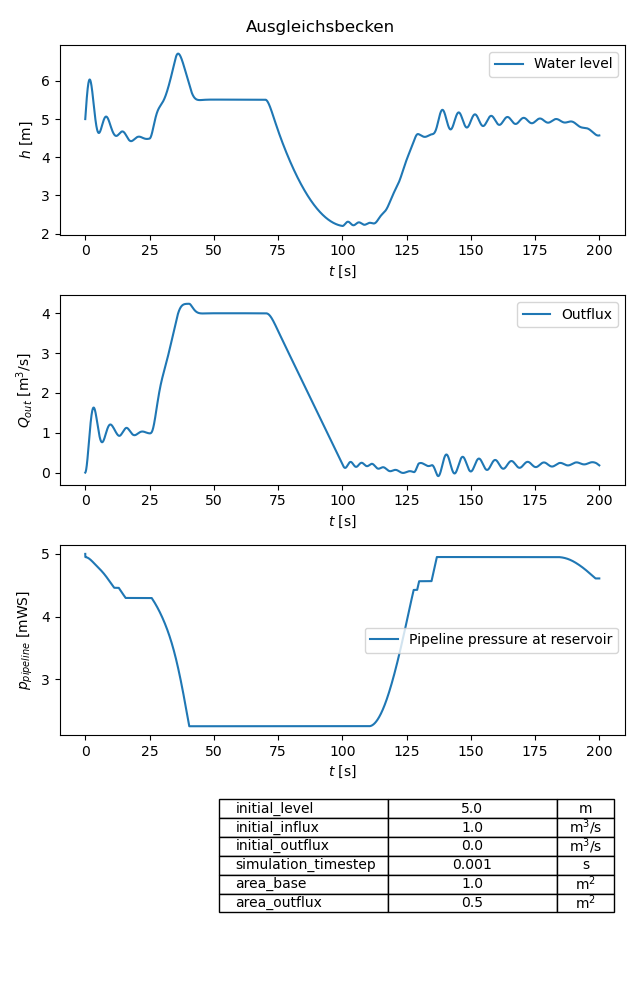

In [8]:
%matplotlib widget

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig1.set_figheight(10)
fig1.suptitle('Ausgleichsbecken')

ax1.plot(time_vec[:i_max],level_vec[:i_max], label='Water level')
ax1.set_ylabel(r'$h$ ['+V.level_unit+']')
ax1.set_xlabel(r'$t$ ['+V.time_unit+']')
ax1.legend()

ax2.plot(time_vec[:i_max],outflux_vec[:i_max], label='Outflux')
ax2.set_ylabel(r'$Q_{out}$ ['+V.flux_unit+']')
ax2.set_xlabel(r'$t$ ['+V.time_unit+']')
ax2.legend()

ax3.plot(time_vec[:i_max],pressure_conversion(pressure_vec[:i_max],'Pa',conversion_pressure_unit)[0], label='Pipeline pressure at reservoir')
ax3.set_ylabel(r'$p_{pipeline}$ ['+conversion_pressure_unit+']')
ax3.set_xlabel(r'$t$ ['+V.time_unit+']')
ax3.legend()

# plt.subplots_adjust(left=0.2, bottom=0.2)
ax4.set_axis_off()
cell_text = np.array([[initial_level, V.level_unit], \
            [initial_influx, V.flux_unit], \
            [initial_outflux, V.flux_unit], \
            [simulation_timestep, V.time_unit], \
            [area_base, V.area_unit], \
            [area_outflux, V.area_unit]])

row_labels =['initial_level', \
            'initial_influx', \
            'initial_outflux', \
            'simulation_timestep', \
            'area_base', \
            'area_outflux']

plt.table(cellText=cell_text, \
            cellLoc='center', \
            colWidths=[0.3,0.1,0.3], \
            rowLabels=row_labels, \
            loc = 1, \
            rowLoc='left', \
            fontsize = 15.)

fig1.tight_layout()            